# Advanced Lane Lines

In this project, the goal is to write a software pipeline to identify the lane boundaries in a video

The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8/ Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle
position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

# 1. Camera Calibration

The code for this step is contained in the first code cell of the IPython notebook.

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  


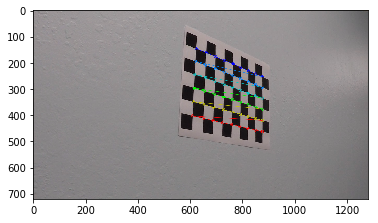

In [2]:
# arrays to store object points and image points from all the images
objpoints = []  # 3D points in real world space
imgpoints = []   # 2D points in image plane

# prepare object points like (0,0,0),(1,0,0)...
objp = np.zeros(((9*6,3)),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# make a list of all calibration images
images = glob.glob('camera_cal/*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    # read image file
    img = cv2.imread(fname)
    # convert the image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray,(9,6),None)

    # if corners are found, add object points, image points
    if ret==True:
        imgpoints.append(corners)
        objpoints.append(objp)

        # draw and display the corners
        img = cv2.drawChessboardCorners(img,(9,6),corners,ret)
        plt.imshow(img)
        
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained the following result:

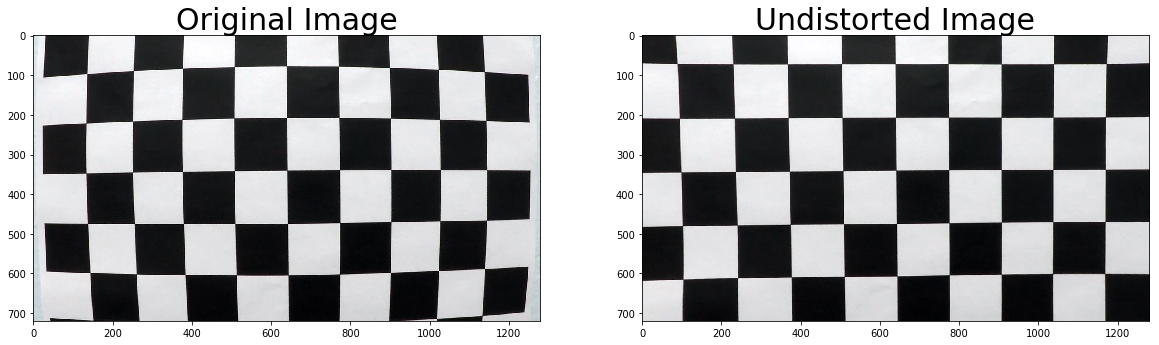

In [3]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2],None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Pipeline for single images

### Correct distortion

In [4]:
# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def cal_undistort(img):
    """Returns undistorted image"""
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

I load the camera parameters previously calculated and use them to undistort the following image

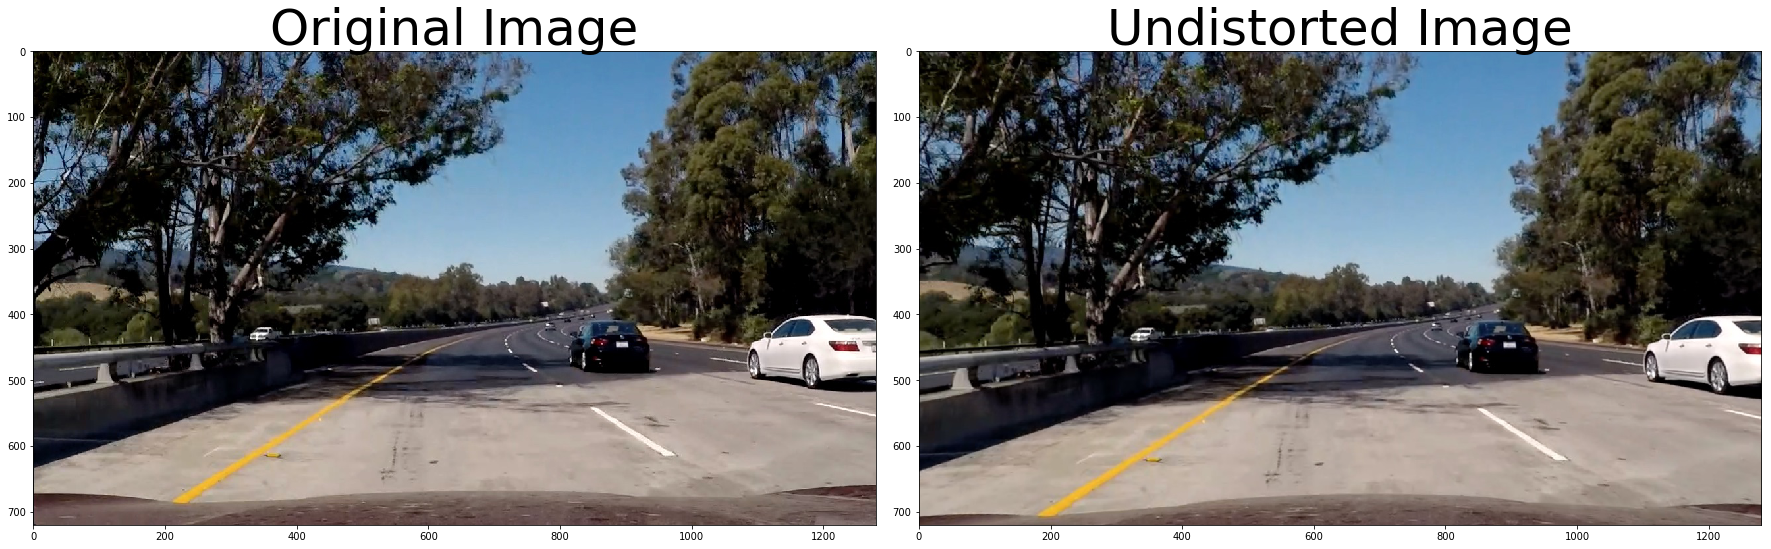

In [5]:
img = cv2.imread("test_images/test5.jpg")
img = np.fliplr(img.reshape(-1,3)).reshape(img.shape)  # cv2.imread loads images in BGR, not RGB
undistorted = cal_undistort(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Create a thresholded binary image

I used a combination of color and gradient thresholds to generate a binary image.

Here we define three procedures to apply calculate the Sobel gradient and create x,y, magnitude or directional threshold 

In [6]:
def abs_sobel_threshold(gray, orient='x', sobel_kernel=3, threshold=(0, 255)):
    """Calculate directional gradient from a grayscale image"""
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= threshold[0]) & (scaled_sobel <= threshold[1])] = 1
    # Return this mask as the binary_output image
    return sbinary

In [7]:
def mag_threshold(gray, sobel_kernel=3, threshold=(0, 255)):
    """Calculate gradient magnitude from a grayscale image"""
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # Calculate the magnitude 
    abs_sobel = np.sqrt(sobelx**2+sobely**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= threshold[0]) & (scaled_sobel <= threshold[1])] = 1
    # Return this mask as your binary_output image
    return sbinary

In [8]:
def dir_threshold(gray, sobel_kernel=3, threshold=(0, np.pi/2)):
    """Calculate direction of the gradient from a grayscale image"""
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    sobel_dir = np.arctan2(abs_sobely, abs_sobelx)

    sbinary = np.zeros_like(sobel_dir)
    sbinary[(sobel_dir >= threshold[0]) & (sobel_dir <= threshold[1])] = 1
    
    return sbinary


Define a color binary threshold

In [9]:
def color_threshold(img,threshold=(0,255)):
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= threshold[0]) & (s_channel <= threshold[1])] = 1
    
    return s_binary
    

Build processing pipeline to combine the different threshold methods

In [10]:
def build_binary_threshold(img):
    # Choose a Sobel kernel size
    ksize = 3 
    
    # Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_threshold(gray, orient='x', sobel_kernel=ksize, threshold=(20, 100))
    grady = abs_sobel_threshold(gray, orient='y', sobel_kernel=ksize, threshold=(20, 100))
    mag_binary = mag_threshold(gray, sobel_kernel=ksize, threshold=(30, 100))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, threshold=(0.9,1.3))
    
    # apply color threshold
    color_bin = color_threshold(img,threshold=(170,255))
    
    # combine the different masks
    combined = np.zeros_like(gradx)
    combined[((gradx == 1)&(grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[( (color_bin == 1)| (combined==1))] = 1
       
    return combined

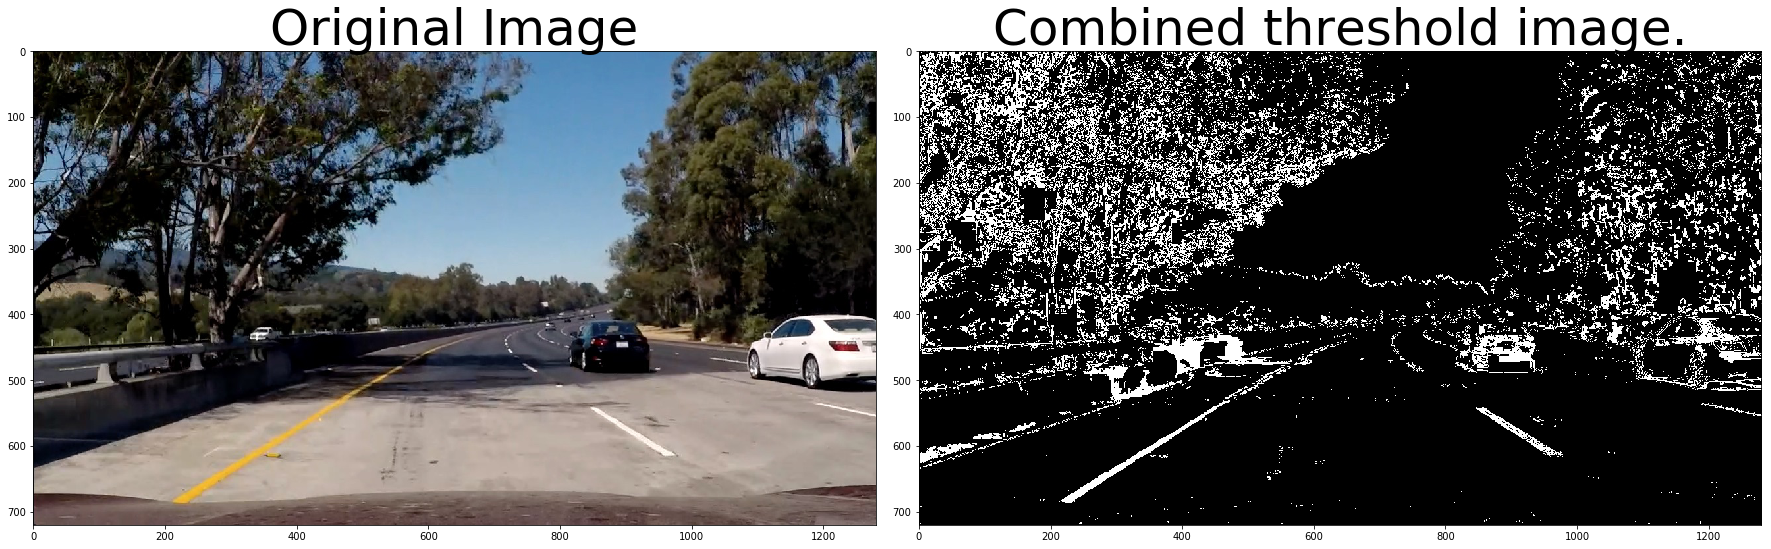

In [11]:
# load test image and apply transformation
img = cv2.imread("test_images/test5.jpg")
img = np.fliplr(img.reshape(-1,3)).reshape(img.shape)
binary_img = build_binary_threshold(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary_img, cmap='gray')
ax2.set_title('Combined threshold image.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Perspective Transform

Next, we want to identify four source points for the perspective transform. In this case, we assume the road is a flat plane. This isn't strictly true, but it can serve as an approximation for this project. We pick four points in a trapezoidal shape that would represent a rectangle when looking down on the road from above.

The code for my perspective transform includes a function called `warper()`.  The `warper()` function takes as inputs an image (`img`).  I chose the hardcode the source and destination points in the following manner:

```python
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
```

This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 585, 460      | 320, 0        | 
| 203, 720      | 320, 720      |
| 1127, 720     | 960, 720      |
| 695, 460      | 960, 0        |

I verified that the perspective transform is working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

In [12]:
def warper(img):
    # define calibration box in source (original) and destination (desired or wrapped) coordinates
    img_size = (img.shape[1],img.shape[0])
    # source coordinates
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    # desired coordinates
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    # compute the perspective transform
    M = cv2.getPerspectiveTransform(src,dst)
    # create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    
    return warped,src,dst

In [13]:
img = cv2.imread('test_images/straight_lines1.jpg')
img = np.fliplr(img.reshape(-1,3)).reshape(img.shape)
warped_img,src,dst = warper(img)
src_x = [p[0] for p in src]
src_y = [p[1] for p in src]
dst_x = [p[0] for p in dst]
dst_y = [p[1] for p in dst]

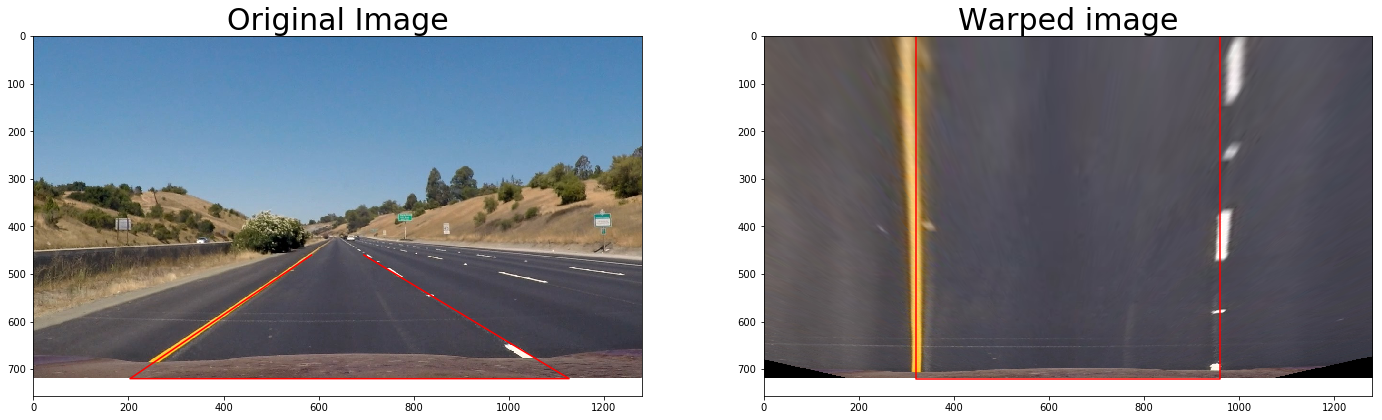

In [14]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax1.plot(src_x,src_y,'r')
ax2.imshow(warped_img)
ax2.set_title('Warped image', fontsize=30)
ax2.plot(dst_x,dst_y,'r')

### Line finding method : sliding windows

After applying calibration, thresholding, and a perspective transform to a road image, you should have a binary image where the lane lines stand out clearly. However, you still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.

I first take a histogram along all the columns in the lower half of the image. With this histogram I am adding up the pixel values along each column in the image. In my thresholded binary image, pixels are either 0 or 1, so the two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines. I can use that as a starting point for where to search for the lines. From that point, I can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.

In [15]:
img = cv2.imread('test_images/test2.jpg')
img = np.fliplr(img.reshape(-1,3)).reshape(img.shape)

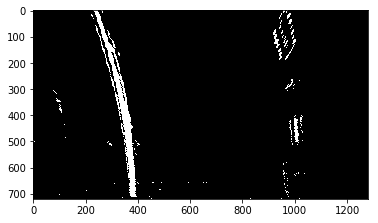

In [16]:
# correct distortion
undistort = cal_undistort(img)
# get binary img
binary_img = build_binary_threshold(undistort)
# perpective transform
binary_warped,src,dst = warper(binary_img)

plt.imshow(binary_warped,cmap='gray')

In [17]:
def sliding_windows(binary_warped):

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit,right_fit,out_img,nonzerox,nonzeroy,left_lane_inds,right_lane_inds

In [18]:
# apply sliding windows
left_fit,right_fit,out_img,nonzerox,nonzeroy,left_lane_inds,right_lane_inds = sliding_windows(binary_warped)

c:\miniconda3\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(720, 0)

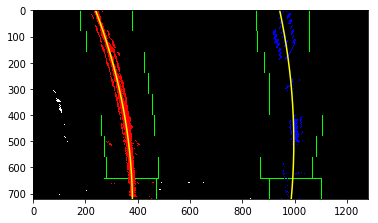

In [19]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

Now we know where the lines are we have a fit! In the next frame of video we don't need to do a blind search again, but instead we can just search in a margin around the previous line position like this:

In [20]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

Let's visualize the search window area 

(720, 0)

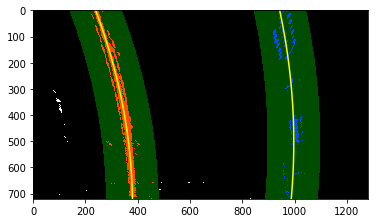

In [21]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Radius of curvature and position of the vehicle

First we calculate the radius of curvature in the pixel space, and then we convert it to actual meters. The values we get for the test image are 675m and 784m. This is the right order of magnitude. We also calculate the offset between the camera and the center of the lane.

In [22]:
def curve_radius_and_offset(img,left_fit,right_fit,leftx,lefty,rightx,righty):
    # Define y-value where we want radius of curvature, at the bottom of the image
    y_eval = img.shape[0]
        
    # calculate the curve radius in the pixel space
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # calculate the car offset
    left_x = left_fit[0]*ploty[-1]**2 + left_fit[1]*ploty[-1] + left_fit[2]
    right_x = right_fit[0]*ploty[-1]**2 + right_fit[1]*ploty[-1] + right_fit[2]
    lane_center = (right_x-left_x)/2
    camera_center = img.shape[0]/2
    offset = (camera_center-lane_center)*xm_per_pix
    
    return left_curverad, right_curverad, offset


In [23]:
left_curverad, right_curverad, offset = curve_radius_and_offset(binary_warped,left_fit,right_fit,leftx,lefty,rightx,righty)
print(left_curverad, 'm', right_curverad, 'm',offset,'m')

655.517479805 m 776.68203725 m 0.298298771817 m


### Example

We have a warped binary image called wrapped_img, and we have fit the lines with a polynomial and have arrays called ploty, left_fitx and right_fitx, which represent the x and y pixel values of the lines. We can then project those lines onto the original image as implemented in the function "map_lane" of the Jupyter notebook.

In [24]:
def map_lane(undistort_img,wrapped_img,left_fitx,right_fitx,ploty):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(wrapped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # get inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistort_img.shape[1], undistort_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistort_img, 1, newwarp, 0.3, 0)
    
    return result
    

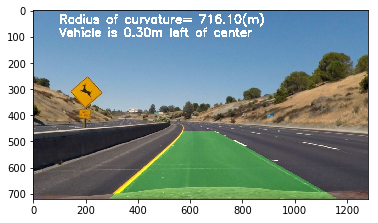

In [25]:
result = map_lane(undistort,binary_warped,left_fitx,right_fitx,ploty)

# add text
cv2.putText(result, "Radius of curvature= {:.2f}(m)".format((left_curverad+right_curverad)/2), (100,50), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),5)
if offset<0:
    cv2.putText(result, "Vehicle is {:.2f}m right of center".format(offset), (100,10), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),5)
else:
    cv2.putText(result, "Vehicle is {:.2f}m left of center".format(offset), (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),5)
plt.imshow(result)

# Video Pipeline

Now we apply the image processing pipeline to a entire video

In [26]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()

In [27]:
video = VideoFileClip("project_video.mp4")

In [62]:
# we average the polynomial fits over the last 10 frames in order to avoid anomalies
N_FRAMES = 10

# define a data structure to record the position of each line
class Line():
    
    def __init__(self):
        # fit from the last frame
        self.last_fit = None
        # fits from the last n frames
        self.recent_fits = []
        # radius
        self.radius = None
        # radius from the last n frames
        self.recent_radius = []
    
    def add_fit(self,fit):
        self.last_fit = fit
        self.recent_fits.append(fit)
        if len(self.recent_fits)>N_FRAMES:
            self.recent_fits.pop(0)  # remove the oldest fit
            
    def mean_fit(self):
        s = np.array([0.,0.,0.])
        for f in self.recent_fits:
            s+=f
        return s/len(self.recent_fits)
    
    def add_radius(self,r):
        self.radius = r
        self.recent_radius.append(r)
        if len(self.recent_radius)>N_FRAMES:
            self.recent_radius.pop(0)  # remove the oldest radius
            
    def mean_radius(self):
        s = 0
        for r in self.recent_radius:
            s+=r
        return s/len(self.recent_radius)
    

In [63]:
left_line = Line()
right_line = Line()

In [64]:
stats = { 'use_previous' : 0, 'use_sliding_windows': 0}

In [65]:
def find_lane_position(binary_warped):
    global left_line
    global right_line
    
    global stats
    
    # get position from previous frame
    left_fit = left_line.last_fit
    right_fit = right_line.last_fit
    
    if not ((left_fit is None) or (right_fit is None)):
        
        # Set minimum number of pixels found to recenter window
        minpix = 50
    
        # first, search for the line around positions at the previous frame
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # If we found > minpix pixels, recenter next window on their mean position
        if (len(left_lane_inds) > minpix) and len(right_lane_inds) > minpix:
            
            stats['use_previous'] +=1 
            
            # extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
        else:
            left_fit = None
            right_fit = None
        
    # if we haven't found the lines, use sliding windows search
    if (left_fit is None) or (right_fit is None):
        # sliding windows search
        stats['use_sliding_windows'] +=1 
        left_fit,right_fit,out_img,nonzerox,nonzeroy,left_lane_inds,right_lane_inds = sliding_windows(binary_warped)
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
    return left_fit, right_fit,leftx,lefty,rightx,righty

In [66]:
def process_image(img):
    global left_line
    global right_line
    
    # correct distortion
    undistort = cal_undistort(img)
    # get binary img
    binary_img = build_binary_threshold(undistort)
    # perpective transform
    binary_warped,src,dst = warper(binary_img)
    
    # apply sliding windows
    #left_fit,right_fit,out_img,nonzerox,nonzeroy,left_lane_inds,right_lane_inds = sliding_windows(binary_warped)
    new_left_fit,new_right_fit,leftx,lefty,rightx,righty = find_lane_position(binary_warped)
    
    # update the records
    if not (new_left_fit is None):
        left_line.add_fit(new_left_fit)
    if not (new_right_fit is None):
        right_line.add_fit(new_right_fit)
        
    # use the average for the plotting
    left_fit = left_line.mean_fit()
    right_fit = right_line.mean_fit()
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # display the lanes
    result = map_lane(undistort,binary_warped,left_fitx,right_fitx,ploty)

    # calculate radius of curvature and offset
    new_left_curverad, new_right_curverad, new_offset = curve_radius_and_offset(binary_warped,left_fit,right_fit,leftx,lefty,rightx,righty)
    
    if not (new_left_curverad is None):
        left_line.add_radius(new_left_curverad)
    if not (new_right_curverad is None):
        right_line.add_radius(new_right_curverad)
        
    # average the radius of curvature
    left_curverad = left_line.mean_radius()
    right_curverad = right_line.mean_radius()
    
    # add text
    cv2.putText(result, "Radius of curvature= {:.2f}(m)".format((left_curverad+right_curverad)/2), (100,50), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),5)
    if offset<0:
        cv2.putText(result, "Vehicle is {:.2f}m right of center".format(offset), (100,10), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),5)
    else:
        cv2.putText(result, "Vehicle is {:.2f}m left of center".format(offset), (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),5)
    
    return result

Test the processing function on the test images

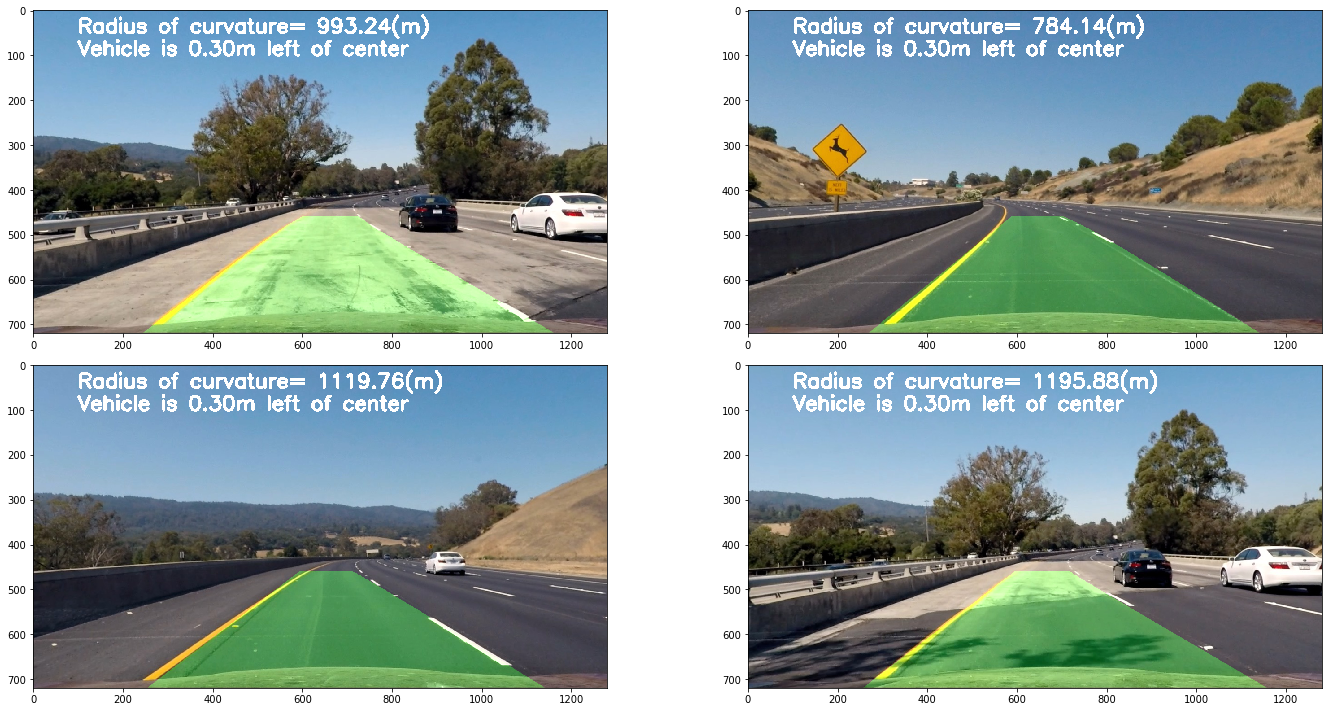

In [67]:
f, axarr  = plt.subplots(2, 2, figsize=(20,10))
f.tight_layout()

for j in range(1,5):
    file = "test_images/test{}.jpg".format(j)
    img = cv2.imread(file)
    img = np.fliplr(img.reshape(-1,3)).reshape(img.shape)
    r = process_image(img)
    if j<3:
        i=0
    else:
        i=1
        j=j-2
    axarr[i,j-1].imshow(r)


Use the pipeline to generate the output video

In [ ]:
result_video = video.fl_image(process_image)
%time result_video.write_videofile("output.mp4", audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


 23%|██████████████████▉                                                                 | 284/1261 [01:09<04:04,  3.99it/s]